In [10]:
from pyspark.sql import SparkSession 

# Initialising Spark Session
spark = SparkSession \
    .builder \
    .appName("Python Spark - Average Tempo of Spotify Songs for each Decade") \
    .getOrCreate()

In [9]:
# Used for stopping spark session
#spark.stop()

In [12]:
# Constants defining streaming parammeters
TOPIC = 'groupB04.spotifytempos'
STARTING_OFFSETS = "latest"

In [13]:
# Starting spark data frame
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "node1:9092") \
  .option("subscribe", TOPIC) \
  .option("startingOffsets",STARTING_OFFSETS) \
  .option("failOnDataLoss", "false")\
  .option("checkpointLocation", "/tmp/b6") \
  .load() 

In [14]:
# Checking if everything works by printing the schema of the data
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [15]:
from pyspark.sql.functions import get_json_object, concat, lit
from pyspark.sql.types import *
from pyspark.sql import functions as f

# Since our data is in CSV format, we get each variable by spliting our message by ','
split_col = f.split(df['value'], ',')

# Constructing the decade string for each song which will be used later in aggregation
decade = concat(split_col.getItem(1)[0:3], lit('0s'))

# Adding new columns to our data frame
df = df \
         .withColumn('UUID', split_col.getItem(0)) \
         .withColumn('year', split_col.getItem(1)) \
         .withColumn('tempo', split_col.getItem(2)) \
         .withColumn('decade', decade) \

# Converting our dataframe to values in correct types
converted = df \
    .selectExpr("UUID", "year", "tempo", "offset", "decade")\
    .select([\
            df["UUID"].cast(StringType()), \
            df["year"].cast(IntegerType()), \
            df["tempo"].cast(DoubleType()), \
            df["decade"].cast(StringType()).alias("Decade")\
            ])

In [16]:
# Doing the calculations - grouping by the decade and calculating the tempo average
groupdf = converted \
    .select("UUID", "year", "Decade", "tempo", "offset") \
    .groupby("Decade") \
    .agg( \
         # Calculating average tempo of decade rounded to 2 decimal places
         f.round(f.avg("tempo"), 2).alias("Average Tempo"), \
         # Adding to df some additional data about number of songs used for calculation
         f.approxCountDistinct("UUID").alias("Songs Count"), \
         # Adding to df some additional data about number of years from given decade used for calculation
         f.approxCountDistinct("year").alias("Years Count")) \
    .sort("Decade")

In [17]:
%matplotlib inline
from pyspark.sql import SparkSession
from IPython import display
import matplotlib.pyplot as plt

# Defining the function that will be used for representing our data in real time (incrementaly)
def show_plot_and_df(epoch_frame, epoch_id):
    if (epoch_frame.count()==0):
        print("Waiting for new messages...")
        return
    # Printing plot with approprate labels
    epoch_frame.toPandas().plot(kind='bar', x='Decade', y='Average Tempo')
    display.clear_output(wait=True)
    plt.title("Average Tempo of Spotify Songs across Decades")
    plt.ylabel("Tempo in BPM")
    plt.xlabel("Decade")
    plt.gca().set_ylim([70,160])
    plt.show()
    # Printing dataframe
    epoch_frame.show()
    # Printing current iteration
    print("Current Epoch: " + str(epoch_id))
    


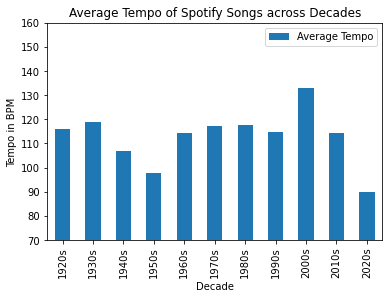

+------+-------------+-----------+-----------+--------------+
|Decade|Average Tempo|Songs Count|Years Count|Current Offset|
+------+-------------+-----------+-----------+--------------+
| 1920s|       115.97|          2|          1|           176|
| 1930s|       118.83|          5|          3|           207|
| 1940s|       106.79|         14|          7|           215|
| 1950s|        97.66|         19|         10|           313|
| 1960s|       114.39|         18|         10|           314|
| 1970s|       117.26|         20|         10|           288|
| 1980s|       117.77|         19|         10|           289|
| 1990s|       114.87|         18|         10|           315|
| 2000s|        133.0|         19|         10|           298|
| 2010s|        114.3|         11|         10|           259|
| 2020s|        90.05|          1|          1|            83|
+------+-------------+-----------+-----------+--------------+

Current Epoch: 6


In [18]:
# Defining some parammeters
processingTime = "5 Seconds"
outputMode = "complete"

# Finally, showing the data which updates every processingTime seconds
df = groupdf \
    .writeStream \
    .outputMode(outputMode) \
    .foreachBatch(show_plot_and_df) \
    .trigger(processingTime=processingTime) \
    .start() \
    .awaitTermination()

In [19]:
# After finish we can stop spark session
spark.stop()